In [1]:
!pip install transformers datasets pandas seaborn matplotlib wordcloud scikit-learn

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score
import torch

In [3]:
!pip install --upgrade datasets fsspec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [ ]:
# Load the emotion tweet dataset
dataset = load_dataset("dair-ai/emotion")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
df = pd.DataFrame(dataset["train"])
label_names = dataset["train"].features["label"].names
df["label_name"] = df["label"].apply(lambda x: label_names[x])


**Explore the dataset **


<ipython-input-5-8af8c341d00d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label_name", palette="Set2")


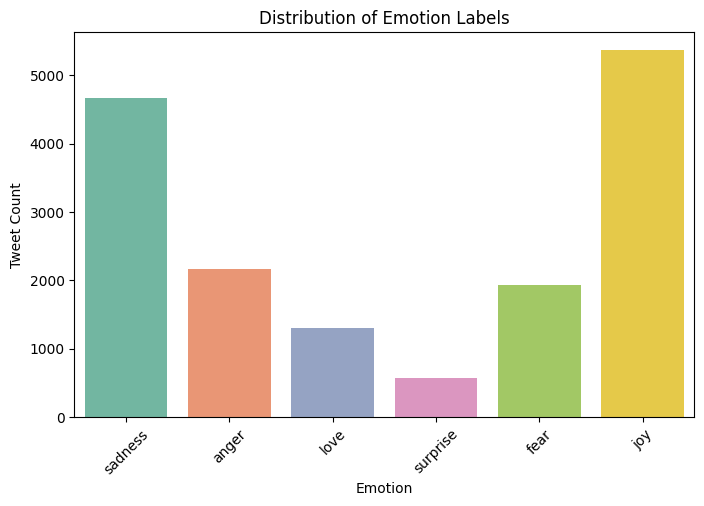

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="label_name", palette="Set2")
plt.title("Distribution of Emotion Labels")
plt.xlabel("Emotion")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.show()


In [6]:
#  Sample Tweets per Emotion
for emotion in label_names:
    print(f"\n--- {emotion.upper()} ---")
    sample_texts = df[df["label_name"] == emotion]["text"].sample(2, random_state=1).values
    for text in sample_texts:
        print(f"• {text}")



--- SADNESS ---
• i still feel guilty to this day for taking a spot
• i feel so empty and cold inside

--- JOY ---
• i was feeling eager to press on
• im actually feeling a little smug

--- LOVE ---
• i met a really cute girl who i feel kind of fond for today and normally girls are really complex to me but i can just be myself around her
• i wake up i realize that my panty is wet and i feel very horny

--- ANGER ---
• i plot that makes the reader feel like he is with owen morgan during his dangerous undertaking
• i feel i really wronged commodore

--- FEAR ---
• i feel especially vulnerable to being treated as a second class citizen
• i forgive myself that i have accepted and allowed myself to feel terrified when i can not move myself or speak or scream in sleep paralysis

--- SURPRISE ---
• i feel so weird about it
• im not sure if anyone else will feel these but i was pleasantly surprised by my read of the first and second book


In [7]:
# Preprocessing for BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

encoded_dataset = dataset.map(tokenize, batched=True)
encoded_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:
train_dataset = encoded_dataset["train"]
val_dataset = encoded_dataset["validation"]
test_dataset = encoded_dataset["test"]


In [9]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from transformers import TrainingArguments

In [ ]:
training_args= TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs",
     fp16=True,                     # ← enable mixed precision 
    gradient_accumulation_steps=2, # ← accumulate grads to simulate batch=32
)


In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


In [14]:
from transformers import DataCollatorWithPadding

# Auto-pad all batches using the tokenizer's pad token
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [15]:
# train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)



In [16]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yossifreda500 (yossifreda500-corelia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.425800
1000,0.122000
1500,0.084800


TrainOutput(global_step=1500, training_loss=0.21086231740315756, metrics={'train_runtime': 329.1714, 'train_samples_per_second': 145.821, 'train_steps_per_second': 4.557, 'total_flos': 2055637166515776.0, 'train_loss': 0.21086231740315756, 'epoch': 3.0})

In [17]:
results = trainer.evaluate(test_dataset)
print(f"\n✅ Accuracy on Test Set: {results['eval_accuracy']:.2f}")



✅ Accuracy on Test Set: 0.94
